In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
from sklearn.metrics import roc_auc_score



import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

import sys
sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
sys.path.append('/input/multiple-annotators-c')
from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

In [2]:
train_data = tf.data.experimental.load('/kaggle/input/cat-dogs-mv/cats_dogs_MV_Tr_1')
Test_data = tf.data.experimental.load('../input/catsvsdog-ma/cats_dogs_Te')


2023-02-04 13:07:06.476017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:07:06.670398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:07:06.671506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:07:06.673131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
image_count_train = tf.data.experimental.cardinality(train_data).numpy()
image_count_train

18610

In [4]:
image_count_test = tf.data.experimental.cardinality(Test_data).numpy()
image_count_test

4652

In [5]:
subset = 18610
train_data = train_data.take(18610)
image_count1 = tf.data.experimental.cardinality(train_data).numpy()
image_count1

18610

In [6]:
image_count = 3000
 
val_size = int(image_count1 * 0.25)
train_ds = train_data.skip(val_size)
val_ds  = train_data.take(val_size)

In [7]:
image_count_val = tf.data.experimental.cardinality(val_ds).numpy()
image_count_val

4652

In [8]:
image_count_Tr = tf.data.experimental.cardinality(train_ds).numpy()
image_count_Tr

13958

2023-02-04 13:07:10.937008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


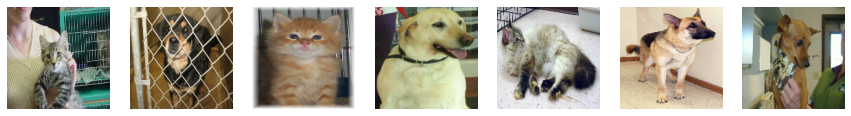

In [9]:
classNames = ['cat', 'dog']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(15,15))
 
for image,label, label2 in train_ds.take(7):
 #  print(image.shape)
 #   predictedLabel = int(predictions[i] >= 0.5)
   # print(label)
   ax[i].axis('off')
  # ax[i].set_title(classNames[label.numpy()])
   ax[i].imshow(image)
    
   i += 1
 
# plt.show()

In [10]:
# shuffle and create batches before training
batch_size = 128
train_batches = train_ds.shuffle(1024).batch(batch_size)
val_batches  = val_ds.shuffle(1024).batch(batch_size)
test_batches =  Test_data.shuffle(1024).batch(batch_size)

In [11]:
image_count_test = tf.data.experimental.cardinality(test_batches).numpy()
image_count_test

37

**Build the GOLD STANDARD classifier**


This will look familiar to you because it is almost identical to the previous model we built. The key difference is the output is just one unit that is sigmoid activated. This is because we're only dealing with two classes.

In [12]:
def build_base_model():
    # base_model = Sequential()


    # base_model.add( Conv2D(32, (3, 3), activation='relu',
    # input_shape=(150, 150, 3)))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add( Dropout(0.2))

    # base_model.add( Conv2D(64, (3, 3), activation='relu'))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add( Dropout(0.2))

    # base_model.add( Conv2D(128, (3, 3), activation='relu'))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add(Dropout(0.2))

    # base_model.add(Conv2D(256, (3, 3), activation='relu'))
    # base_model.add(MaxPooling2D((2, 2)))
    # base_model.add(Dropout(0.2))

    # base_model.add(Flatten())


    # base_model.add(Dense(256, activation='relu'))
    # base_model.add(Dense(1, activation='sigmoid'))

  
    base_model = Sequential()
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(128))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.2))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [13]:
N_CLASSES = 2
def one_hot(image, ytrue, label):
    one_hot_targets = label  # tf.one_hot(tf.cast(label, tf.int32), N_CLASSES, axis = 1, dtype=tf.int32)
    return image, one_hot_targets

In [14]:
train_batches_MV = train_batches.map(one_hot)

In [15]:
val_batches_MV = val_batches.map(one_hot)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
#y_test= np.asarray([aux[1].numpy() for aux  in Test_data ])
#X_test = np.asarray([aux[0].numpy() for aux  in Test_data ])

Epoch 1/100


2023-02-04 13:07:36.820844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 [==============================] - 64s 440ms/step - loss: 0.8475 - accuracy: 0.5234 - val_loss: 0.7023 - val_accuracy: 0.4886

Epoch 00001: val_loss improved from inf to 0.70234, saving model to model1.h5
Epoch 2/100
110/110 [==============================] - 10s 81ms/step - loss: 0.7402 - accuracy: 0.5287 - val_loss: 0.7016 - val_accuracy: 0.5112

Epoch 00002: val_loss improved from 0.70234 to 0.70155, saving model to model1.h5
Epoch 3/100
110/110 [==============================] - 10s 83ms/step - loss: 0.7068 - accuracy: 0.5494 - val_loss: 0.6970 - val_accuracy: 0.5101

Epoch 00003: val_loss improved from 0.70155 to 0.69698, saving model to model1.h5
Epoch 4/100
110/110 [==============================] - 11s 90ms/step - loss: 0.6917 - accuracy: 0.5707 - val_loss: 0.7064 - val_accuracy: 0.5273

Epoch 00004: val_loss did not improve from 0.69698
Epoch 5/100
110/110 [==============================] - 10s 85ms/step - loss: 0.6794 - accuracy: 0.5830 - val_loss: 0.6902 - val_accura

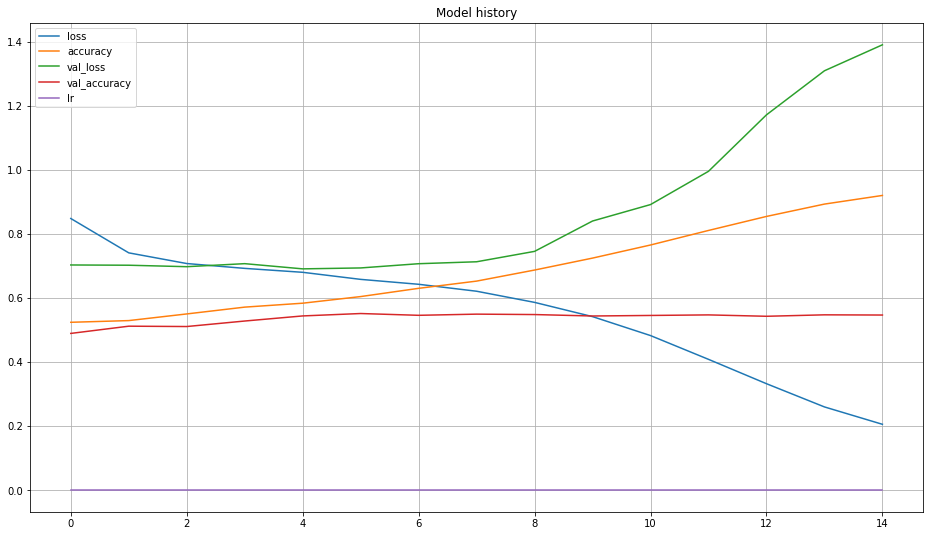

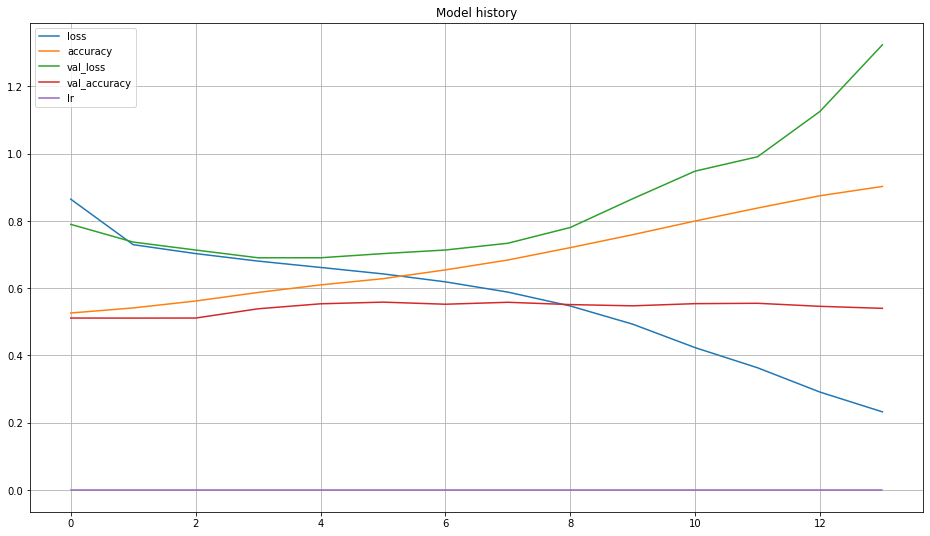

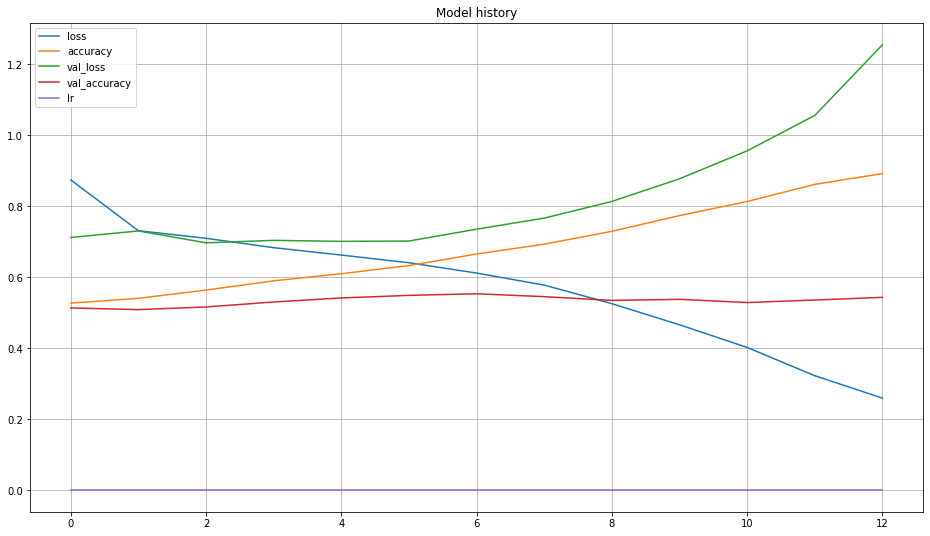

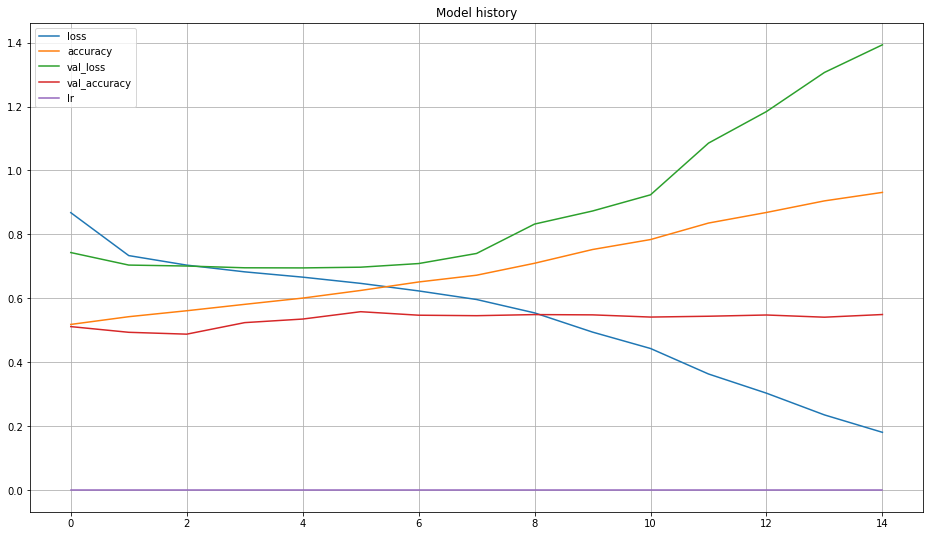

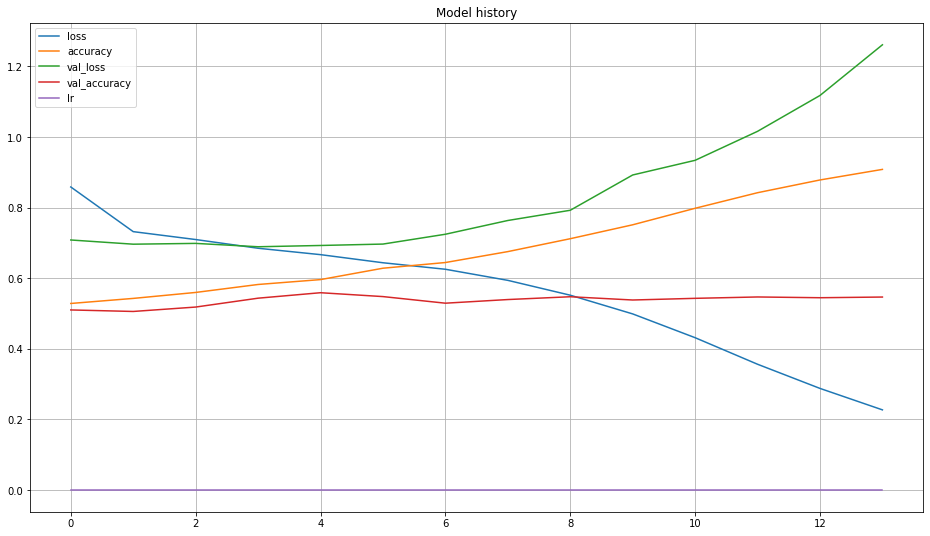

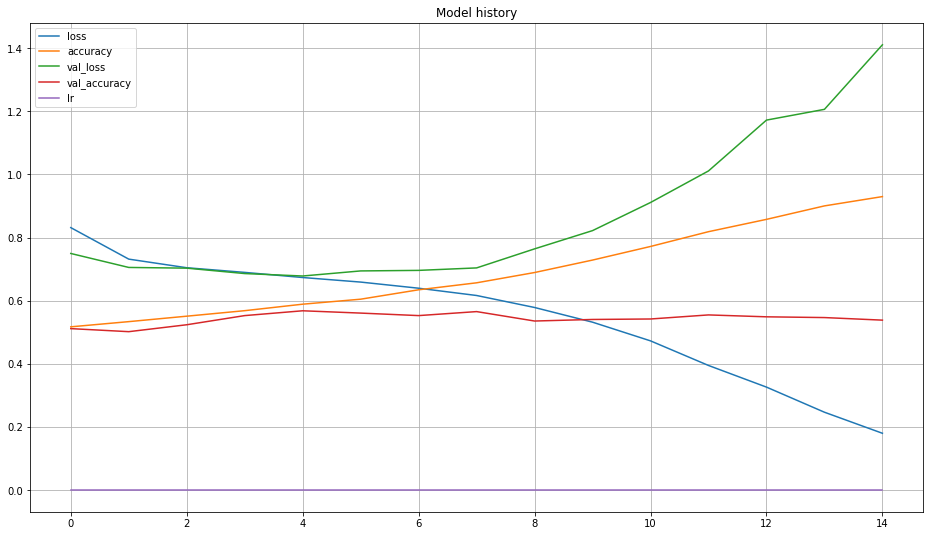

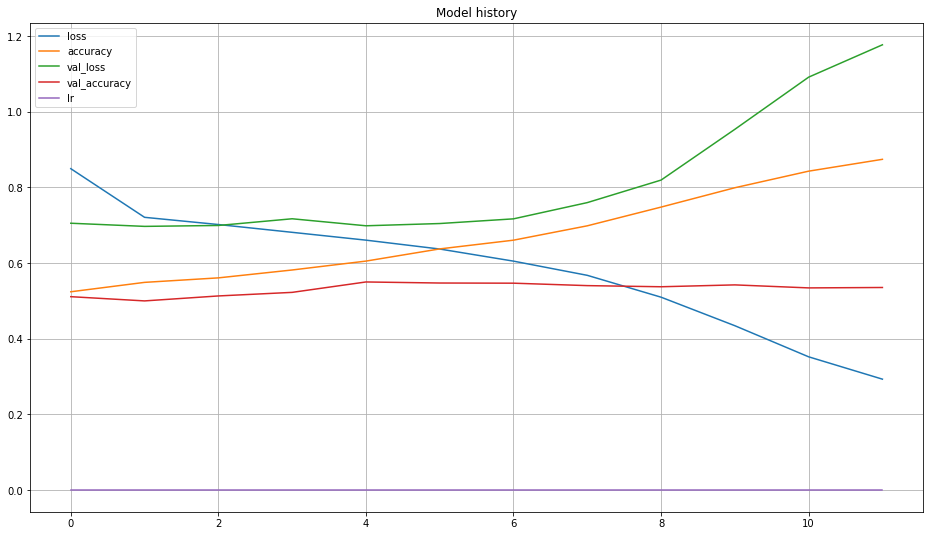

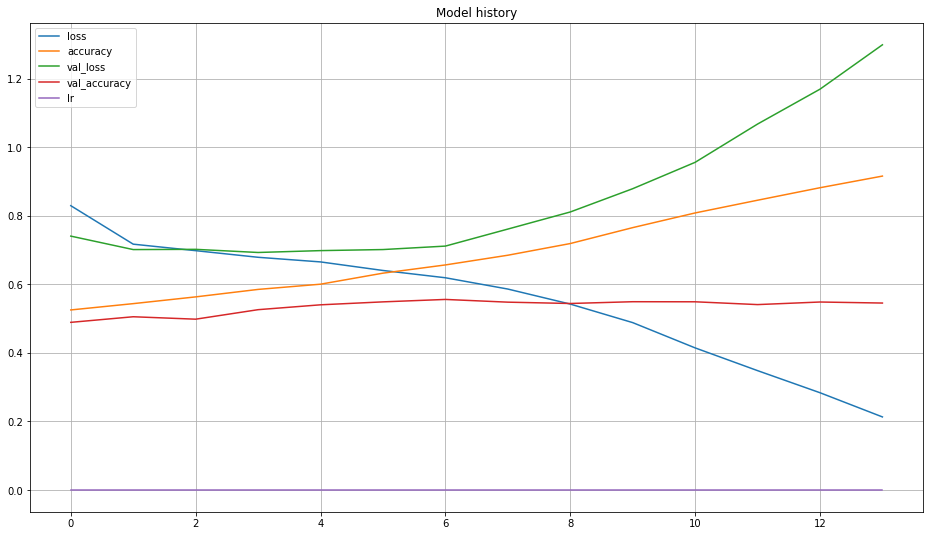

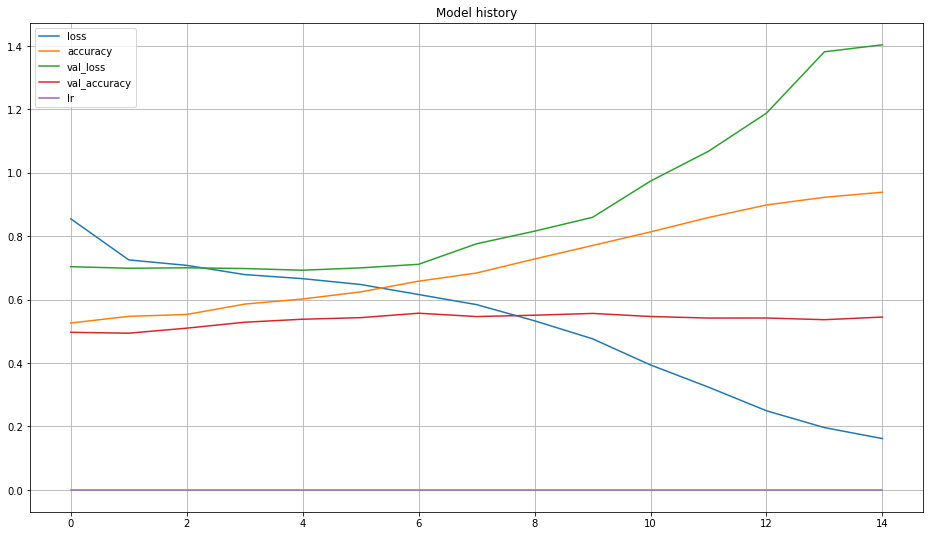

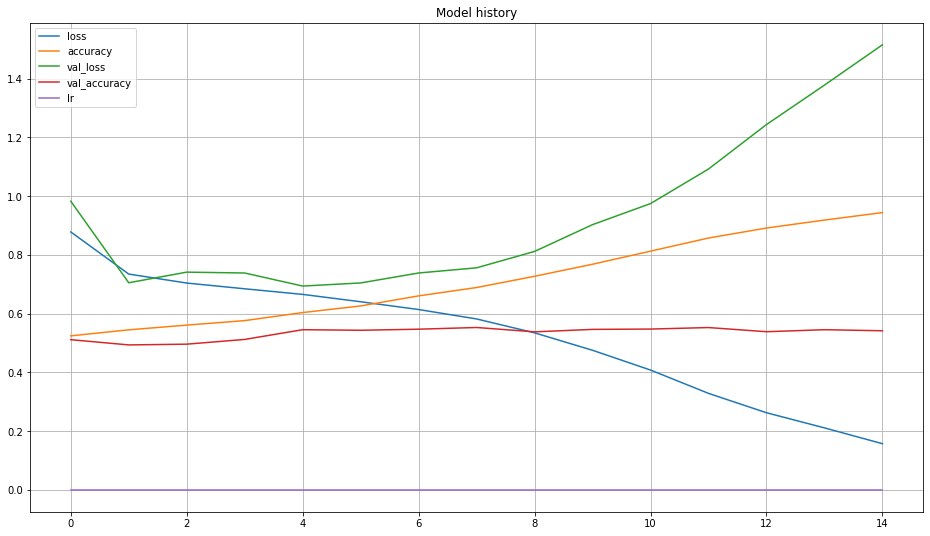

In [18]:
K=2
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
#l1 =0.0001
NUM_RUNS = 10
N_EPOCHS = 100
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
val_acc_goldst = np.zeros(NUM_RUNS)
AUC= np.zeros(NUM_RUNS)
for i in range(NUM_RUNS):
    model = build_base_model()  
    trainHistory = model.fit(train_batches_MV, validation_data= val_batches_MV, epochs=N_EPOCHS,  callbacks=callbacks)
    (loss, accuracy) = model.evaluate(test_batches)
    #Accurarcy =================
    ACC[i] = accuracy
    print("Validation acc: %.4f" % (float(ACC[i]),))
 
    #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val.numpy(), training=False)
       # tf.print(y_batch_val)
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))   #val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))
        val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))
        BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True))
        MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))


    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    #===================================================
    # balanced. Accurcy
    BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI

    MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

    
    
    # Create the history figure
    plt.figure(figsize=(16,9))
    for i in trainHistory.history:
        plt.plot(trainHistory.history[i],label=i)
    plt.title('Model history')
    plt.legend()
    plt.grid()
import pandas as pd

df_gold = pd.DataFrame(val_acc_goldst)
df_gold.to_csv('/kaggle/working/CatDogs_MA_VGG19_GOLD.csv',index=False) # save to notebook output
  

# plt.plot(trainHistory.history['accuracy'])
# plt.plot(trainHistory.history['val_accuracy'])
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Training', 'Validation'])
# plt.grid()
# plt.show()

In [19]:
ACC

array([0.57760102, 0.58447981, 0.58211523, 0.59350818, 0.58383489,
       0.57953566, 0.56706792, 0.59909719, 0.59135854, 0.60189164])

In [20]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  58.599999999999994
Average std:  1.0
Average AUC:  58.63
Average AUC std:  0.98
Average Balanced Accuracy:  16.5
Average std:  0.51
Average MI:  1.72
Average std:  0.09
Average Normalized MI:  2.5
Average std:  0.12
Average Ajdusted MI:  2.5
Average std:  0.12


In [21]:
print('Average Accuracy: ', np.round(val_acc_goldst.mean(),4)*100) 
print('STD Accuracy: ', np.round(np.std(val_acc_goldst),4)*100) 

Average Accuracy:  0.0
STD Accuracy:  0.0


In [22]:
AUC

array([0.5763768 , 0.58470422, 0.58190072, 0.59388918, 0.58451414,
       0.58119142, 0.56806386, 0.59766865, 0.59202796, 0.6026035 ])

In [23]:
print('Average AUC: ', np.round(AUC.mean(),4)*100) 
print('STD AUC: ', np.round(np.std(AUC),4)*100) 

Average AUC:  58.63
STD AUC:  0.98


In [24]:
np.round(np.mean(AUC),4)*100

58.63

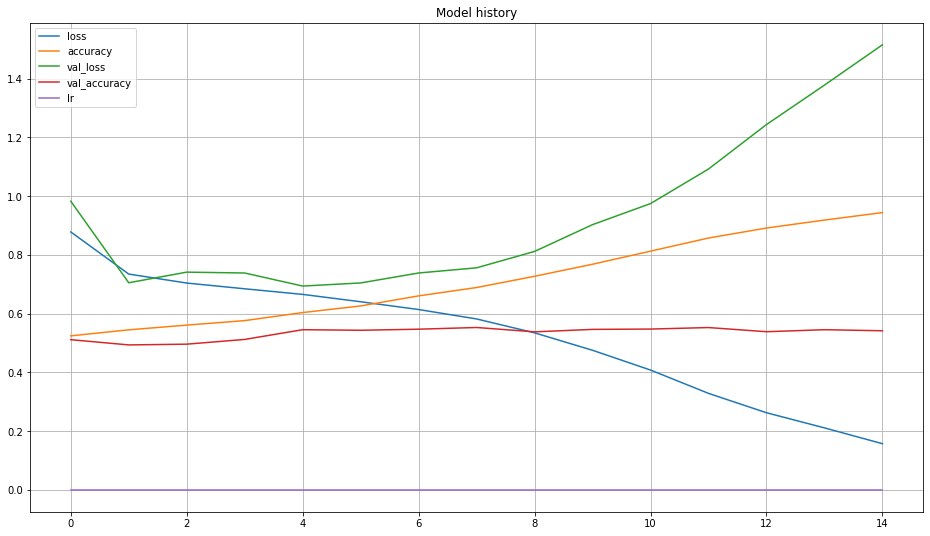

In [25]:
    # Create the history figure
    plt.figure(figsize=(16,9))
    for i in trainHistory.history:
        plt.plot(trainHistory.history[i],label=i)
    plt.title('Model history')
    plt.legend()
    plt.grid()

In [26]:
val_acc_goldst.mean()

0.0

In [27]:
AUC

array([0.5763768 , 0.58470422, 0.58190072, 0.59388918, 0.58451414,
       0.58119142, 0.56806386, 0.59766865, 0.59202796, 0.6026035 ])

In [28]:
print('Average Accuracy: ', np.round( val_acc_goldst.mean(),4)*100) 
print('Average std: ',np.round(np.std( val_acc_goldst),4)*100)

Average Accuracy:  0.0
Average std:  0.0


In [29]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  58.63
Average std:  0.98
